# ExpF.1.ObjectIntration

Author : @leopauly | cnlp@leeds.ac.uk <br>
Program: Studying to what extend does the action vectors learn object inerations

In [1]:
import os
from six.moves import xrange  
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import skimage
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.color import grey2rgb,rgb2grey
from skimage.feature import hog
from skimage import io
import tensorflow as tf
from keras import backend as K
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112
cluster_length=16
feature_size=8192 #4096 #16384
baseline_feature_size=4608
baseline2_feature_size=2


nb_activities=4
nb_videos=5
nb_pixels_per_cell=(8,8)
nb_cells_per_block=(1,1)
nb_orientations=16
saved_path='/nobackup/leopauly/'
dataset_dir='/nobackup/leopauly/S2l/Dataset/Ch4/objinter_dataset/Reach_n_Push/'

### Acitivity net

#### Defining model

In [3]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, 16,height,width,channel],name='x') 

model_keras = md.C3D_ucf101_training_model_tf(summary=False)
out=model_keras(x_image)

/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Thesis_Ch6_B/modelling.py:281: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", input_shape=(16, 112, ..., padding="same")`
  input_shape=input_shape))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Thesis_Ch6_B/modelling.py:283: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  border_mode='valid', name='pool1'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Thesis_Ch6_B/modelling.py:286: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", padding="same")`
  border_mode='same', name='conv2'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Thesis_Ch6_B/modelling.py:288: UserWarning: Update your `MaxPooling3D` call to the Ke

#### Starting a session - Activity Net

In [4]:
#### Start the session with logging placement.
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))

### Restore model weights from previously saved model
saver = tf.train.Saver()
saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-67'))
print("Model restored from file: %s" % saved_path,flush=True)

INFO:tensorflow:Restoring parameters from /nobackup/leopauly/activity_model.ckpt-67
Model restored from file: /nobackup/leopauly/


In [5]:
## Extraction of features - Acitvity net
def extract_activitynet_video_features(vid):
    print('vid.shape',vid.shape)
    vid_=vid.reshape(-1,cluster_length,height,width,channel)
    f_v = sess.graph.get_tensor_by_name('flatten_1/Reshape:0')
    f_v_val=sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })
    features=np.reshape(f_v_val,(-1))
    return features

In [6]:
def get_compress_frames_data(vid_folder, num_frames_per_clip=cluster_length):
  ''' Given a foler with frames from a video, fuction outputs a  num_frames_per_clip images which is the downsampled video'''

  ret_arr = []
  filenames=os.listdir(vid_folder)
  filenames = sorted(filenames)
  jump=math.floor((len(filenames)/num_frames_per_clip))
  loop=0
  for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        image_name = str(vid_folder) + '/' + str(filenames[i])
        img = skimage.io.imread(image_name)  #Image.open
        img=np.array(img)
        img = cv2.resize(img,(crop_size,crop_size))
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr)
  return np.array(ret_arr)

In [7]:
## Extracting activity features from demo video
def activity_feature_extractor(folder):
    vid_folder=dataset_dir+folder
    print('Is the folder present:',os.path.isdir(vid_folder))
    temp_vid=get_compress_frames_data(vid_folder)
    print('Obtained video shape',temp_vid.shape)
    lsp.single_video_inline(temp_vid,0,cluster_length)
    activitynet_features=extract_activitynet_video_features(temp_vid)
    activitynet_features=np.array(activitynet_features)
    return activitynet_features

### Experiment


Is the folder present: True
Obtained video shape (16, 112, 112, 3)


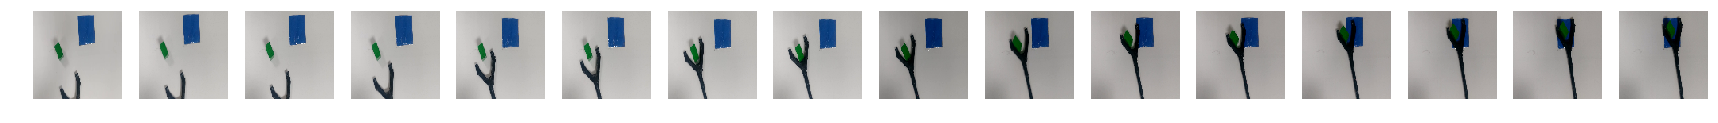

vid.shape (16, 112, 112, 3)


In [8]:
## Demo
activitynet_features_demo=(activity_feature_extractor('demo')) # Demo

#### case 1

Is the folder present: True
Obtained video shape (16, 112, 112, 3)


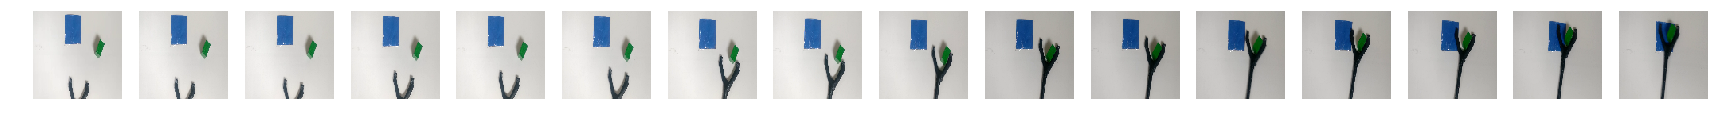

vid.shape (16, 112, 112, 3)
268.115


In [9]:
## A
activitynet_features=(activity_feature_extractor('case1a')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)

Is the folder present: True
Obtained video shape (16, 112, 112, 3)


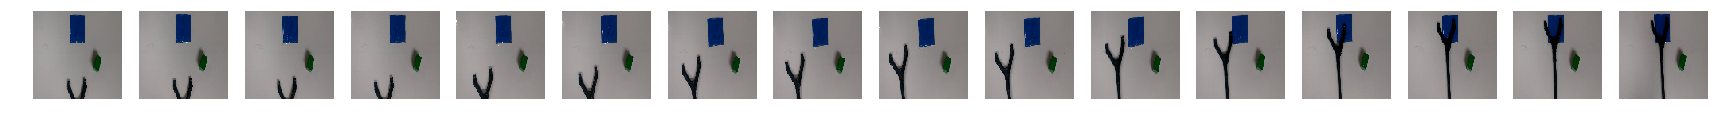

vid.shape (16, 112, 112, 3)
205.357


In [10]:
## B
activitynet_features=(activity_feature_extractor('case1b')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)

Is the folder present: True
Obtained video shape (16, 112, 112, 3)


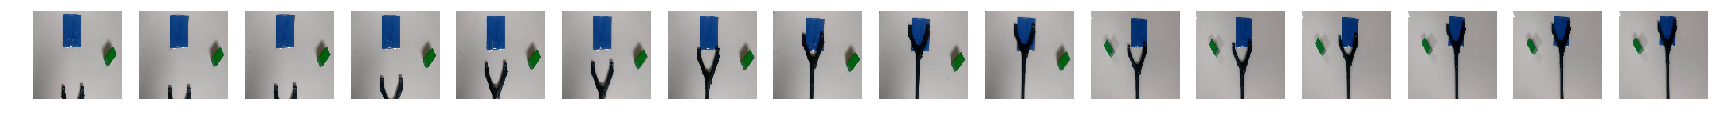

vid.shape (16, 112, 112, 3)
202.088


In [11]:
## C
activitynet_features=(activity_feature_extractor('case1c')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)

#### Misc

Is the folder present: True
Obtained video shape (16, 112, 112, 3)


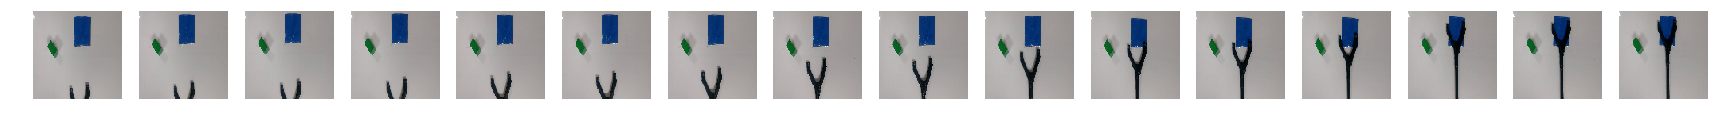

vid.shape (16, 112, 112, 3)
184.511


In [12]:
## Misc
activitynet_features=(activity_feature_extractor('case_misc')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)

Is the folder present: True
Obtained video shape (16, 112, 112, 3)


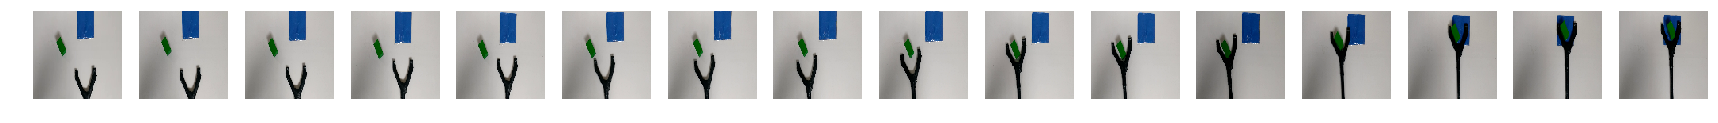

vid.shape (16, 112, 112, 3)
179.175


In [13]:
## Misc
activitynet_features=(activity_feature_extractor('case_misc1')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)

#### case 2

Is the folder present: True
Obtained video shape (16, 112, 112, 3)


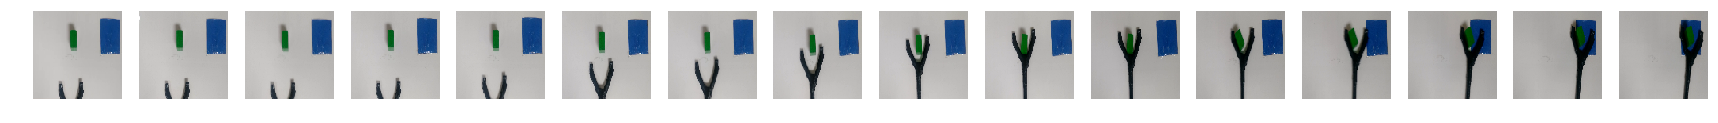

vid.shape (16, 112, 112, 3)
226.33


In [14]:
## A
activitynet_features=(activity_feature_extractor('case2a')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)

Is the folder present: True
Obtained video shape (16, 112, 112, 3)


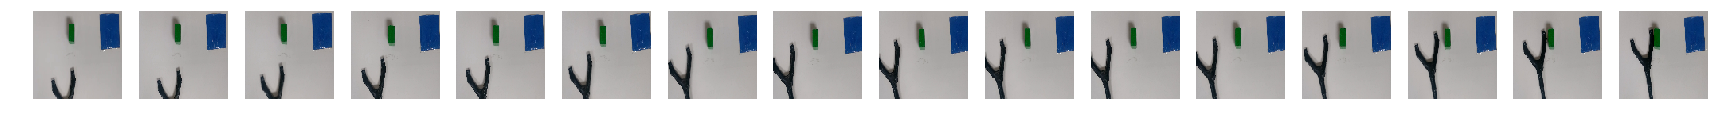

vid.shape (16, 112, 112, 3)
314.68


In [15]:
## B
activitynet_features=(activity_feature_extractor('case2b')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)

Is the folder present: True
Obtained video shape (16, 112, 112, 3)


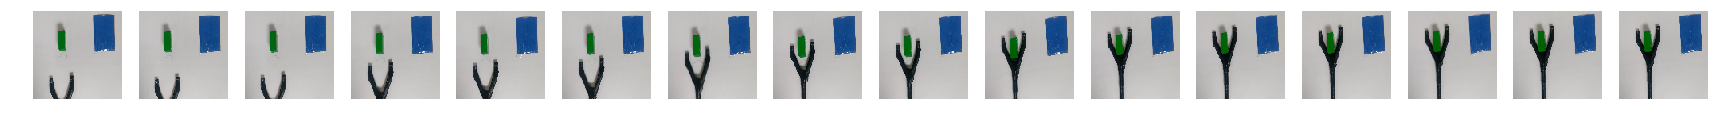

vid.shape (16, 112, 112, 3)
303.432


In [16]:
## C
activitynet_features=(activity_feature_extractor('case2c_new')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)